# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

In [2]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/larissa/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [3]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

# Create Reinforcement Learning Environment

In [4]:
R_TOL = 1.0;
N_WAYPOINTS = 4; # >= 2
SLOW_MODE = false;

In [5]:
# Parametric Constructor for a subtype of AbstractEnv
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv 
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environoments
    visualization::Bool # visualization
    realtime::Bool # realtime
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # Δ time
    
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    norm_way::T
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T # tolerance within drones has to reach waypoint
    projected_position::Vector{T} # projected position of drone along trajectory

    slow_mode::Bool # slow flight learning mode
end

In [6]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along z
            
            typemin(T)..typemax(T), # orientation along x
            typemin(T)..typemax(T), # orientation along z
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x (next gate - current position)
            typemin(T)..typemax(T), # position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # way to next next gate z (next next gate - next gate)
            # TODO: more points?
            ], 
    )
    
    num_waypoints = N_WAYPOINTS # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints + 1) # trajectory with num_waypoints waypoints (+ start point), (with dummy points) 
    reached_goal = falses(num_waypoints)
    
    norm_way = 0.0 
    for i in 1:(num_waypoints - 1)
        norm_way += norm(waypoints[i] - waypoints[i + 1])
    end
    
    if visualization #visualizes VTOL and waypoints
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
        visualize_waypoints(waypoints[1:num_waypoints], 0.15)
    end

    environment = VtolEnv(
        action_space,
        state_space, 
        zeros(T, length(state_space)), # current state, needs to be extended
        rand(action_space), #initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        
        num_waypoints, # includig start point
        waypoints, 
        reached_goal,
        
        norm_way, # norm_way
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3), # projected_position

        SLOW_MODE # slow_mode
    )
    
    
    reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [7]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[6]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, norm_way::T, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T, projected_position::Vector{T}, slow_mode::Bool) where {A, T, ACT, R<:AbstractRNG} in Main at In[5]:3

# Define the RL interface

In [8]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [9]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_position::Vector{T}, v_B::Vector{T}) where T
    
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_position) > d_max
            s_gd = exp(-norm(x_W - projected_position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end;

In [10]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    
    if env.slow_mode
        v_min = 1.0 # min velocity
        v_max = 3.0 # max velocity
        d_max = 0.5 
    else
        v_min = 4.0 # min velocity
        v_max = 50.0 # max velocity
        d_max = 1.0 
    end


    s = scale_for_slowmode(true, v_min, v_max, d_max, env.x_W, env.projected_position, env.v_B)
    
    # TODO: test norming
    k_p = 5.0 * s #/ env.norm_way # factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt) / env.norm_way # factor for reached distance (overall) reward
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 50.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    # factor for too high body rate penalty
    if env.slow_mode
        k_ω = 0.01
    else
        k_ω = 0.001
    end
    norm_ω = norm(env.ω_B[3]) # penalty for body rate

    if env.x_W[3] < -2
        fall = 1
    else
        fall = 0
    end
    
    k_t = 0 # factor for time penalty
    k_d = 0 # factor for distance to next waypoint penalty
    r_d = 0 # penalty for distance to next waypoint
    if !env.slow_mode
        k_t = 0.001 
        k_d = 0.001
        #if env.current_point <= env.num_waypoints
        r_d = norm(env.x_W - env.waypoints[env.current_point]) / env.norm_way 
        #end
        k_s /= env.norm_way
        k_p /= env.norm_way
    end

    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω - fall # - k_t * env.t - k_d * r_d
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [11]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];
    
    
    env.waypoints = generate_trajectory(env.num_waypoints + 1); # Dummy points
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    #env.r_tol = 0.3;
    
    if env.visualization
        visualize_waypoints(env.waypoints[1:env.num_waypoints], 0.15); 
    end
    
    norm_way = 0.0 
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    env.norm_way = norm_way
    env.progress = 0.0;
    env.progress_prev = 0.0;
    
    
    env.state = [env.x_W[1]; # position along x
                 env.x_W[3]; # position along z
        
                 env.R_W[1,1]; # orientation along x
                 env.R_W[3,1]; # orientation along z
        
                 env.v_B[1]; # velocity along x BODY coordinates
                 env.v_B[2]; # velocity along y BODY coordinates  
        
                 env.ω_B[3]; # rotational velocity along z BODY coordinates
        
                 env.waypoints[2][1] - env.x_W[1]; # position error to next gate along x
                 env.waypoints[2][3] - env.x_W[3]; # position error to next gate along z
                 
                 env.waypoints[3][1] - env.waypoints[2][1]; # way to next next gate x 
                 env.waypoints[3][3] - env.waypoints[2][3]] # way to next next gate z 
    
#     if env.num_waypoints >= 3
#         env.state[10] = env.waypoints[3][1] - env.x_W[1]; # way to next next gate x 
#         env.state[11] = env.waypoints[3][3] - env.x_W[3]; # way to next next gate z 
#     end
        
    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    env.projected_position = [0; 0; 0]
    
    nothing

end;

In [12]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # TODO: set flaps later in 3D
    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [13]:
env = VtolEnv();

In [14]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[12]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [15]:
function _step!(env::VtolEnv, next_action)
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    
    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_position = calculate_progress(env.waypoints, env.x_W)
    
    #env.current_point = line_segment + 1

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
        
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.2, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end
    end
 

    env.t += env.Δt
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[3]; # position along z
    
    env.state[3] = env.R_W[1,1]; # orientation along x
    env.state[4] = env.R_W[3,1]; # orientation along z
    
    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates
    
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
    
    # TODO add points
#     if env.current_point <= env.num_waypoints
#         env.state[8] = env.waypoints[env.current_point][1] - env.x_W[1]; # position error along x
#         env.state[9] = env.waypoints[env.current_point][3] - env.x_W[3]; # position error along z
        
#         if env.current_point <= env.num_waypoints - 1
#             env.state[10] = env.waypoints[env.current_point + 1][1] - env.x_W[3]; # way to next next gate x (next next gate - next gate)
#             env.state[11] = env.waypoints[env.current_point + 1][3] - env.x_W[3]; # way to next next gate z (next next gate - next gate)
#         else
#             # todo maybe 2* state?
#             env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
#             env.state[11] = 0.0 # way to next next gate z (next next gate - next gate)
#         end
#     else
#         env.state[8] = 0.0; # position error along x
#         env.state[9] = 0.0; # position error along z
#         env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
#         env.state[11] = 0.0 # way to next next gate z (next next gate - next gate)
#     end
    
    env.state[8] = env.waypoints[env.current_point][1] - env.x_W[1]; # position error along x, dummy integriert
    env.state[9] = env.waypoints[env.current_point][3] - env.x_W[3]; # position error along z, dummy integriert
    
    if env.current_point <= env.num_waypoints
        env.state[10] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1] ; # way to next next gate x (next next gate - next gate), dummy integriert
        env.state[11] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # way to next next gate z (next next gate - next gate), dummy integriert
    end
        
    
    # Termination criteria
    # TODO: Use many termination criteria so that you do not train unnecessarily in wrong areas
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast_point 
        env.x_W[3] < -5.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 3.0 ||# stop after 3s per point
        norm(env.x_W - env.projected_position) > 5.0 || # too far off the path 
        env.reached_goal == trues(env.num_waypoints)

    nothing
end;

In [16]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.8s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.674401253170915e9, 1.674401256008816e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [17]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ])

MultiThreadEnv(8 x VtolEnv)

In [18]:
# Define the function approximator
# TODO: change architecture eventually
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),#
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [19]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # TODO: change eventually to SAC or compare
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/larissa/.julia/packages/Flux/7nTyc/src/functor.jl:187


In [20]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)
    # TODO: slow mode, fast mode
    if SLOW_MODE
        f = joinpath("./RL_models_slow/", "vtol_2D_ppo_$t.bson")
    else
        f = joinpath("./RL_models_fast/", "vtol_2D_ppo_$t.bson") 
    end
    @save f model
    println("parameters at step $t saved to $f")
end;

In [21]:
function loadModel()
    # TODO: slow, fast mode
    f = joinpath("./RL_models_slow/", "vtol_2D_ppo_$(load_from_slow_step).bson") 
    @load f model
    return model
end;

In [22]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

visualize_validation = true; # TODO set as desired
episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = visualize_validation, realtime = visualize_validation);

In [23]:
# number of steps
steps_slow = 1_500_000 
steps_fast = 1_500_000
load_from_slow_step = 500_000 # TODO: choose slow model

steps = 0
if SLOW_MODE
    steps = steps_slow
else
    steps = steps_fast
end

1500000

In [24]:
if !SLOW_MODE
    agent.policy.approximator = loadModel(); 
end;

In [25]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(steps),
    ComposedHook(
        DoEveryNStep(saveModel, n=10_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   0%|                                         |  ETA: 132.29 days

parameters at step 10000 saved to ./RL_models_fast/vtol_2D_ppo_10000.bson


Progress:   1%|▎                                        |  ETA: 4:06:26

test reward at step 10000: 57.187614015759415


Progress:   1%|▌                                        |  ETA: 2:18:09

parameters at step 20000 saved to ./RL_models_fast/vtol_2D_ppo_20000.bson
test reward at step 20000: 70.02769483795325


Progress:   2%|▊                                        |  ETA: 1:41:50

parameters at step 30000 saved to ./RL_models_fast/vtol_2D_ppo_30000.bson
test reward at step 30000: 69.3982602377315


Progress:   3%|█▏                                       |  ETA: 1:28:16

parameters at step 40000 saved to ./RL_models_fast/vtol_2D_ppo_40000.bson
test reward at step 40000: 70.67608443922695


Progress:   3%|█▍                                       |  ETA: 1:16:35

parameters at step 50000 saved to ./RL_models_fast/vtol_2D_ppo_50000.bson
test reward at step 50000: 71.16770861119645


Progress:   4%|█▋                                       |  ETA: 1:09:26

parameters at step 60000 saved to ./RL_models_fast/vtol_2D_ppo_60000.bson
test reward at step 60000: 72.57502019028595


Progress:   5%|█▉                                       |  ETA: 1:03:26

parameters at step 70000 saved to ./RL_models_fast/vtol_2D_ppo_70000.bson
test reward at step 70000: 69.26364235003369


Progress:   5%|██▏                                      |  ETA: 0:59:14

parameters at step 80000 saved to ./RL_models_fast/vtol_2D_ppo_80000.bson
test reward at step 80000: 71.94669882804186


Progress:   6%|██▍                                      |  ETA: 0:57:10

parameters at step 90000 saved to ./RL_models_fast/vtol_2D_ppo_90000.bson
test reward at step 90000: 70.13586113304964


Progress:   7%|██▊                                      |  ETA: 0:53:46

parameters at step 100000 saved to ./RL_models_fast/vtol_2D_ppo_100000.bson
test reward at step 100000: 42.456545166930475


Progress:   7%|███                                      |  ETA: 0:52:04

parameters at step 110000 saved to ./RL_models_fast/vtol_2D_ppo_110000.bson
test reward at step 110000: 69.98525856580993


Progress:   8%|███▎                                     |  ETA: 0:50:45

parameters at step 120000 saved to ./RL_models_fast/vtol_2D_ppo_120000.bson
test reward at step 120000: 71.28708026893689


Progress:   9%|███▌                                     |  ETA: 0:49:00

parameters at step 130000 saved to ./RL_models_fast/vtol_2D_ppo_130000.bson


Progress:   9%|███▌                                     |  ETA: 0:49:29

test reward at step 130000: 72.18923843686056


Progress:   9%|███▉                                     |  ETA: 0:47:23

parameters at step 140000 saved to ./RL_models_fast/vtol_2D_ppo_140000.bson
test reward at step 140000: 70.25446790366757


Progress:  10%|████                                     |  ETA: 0:46:29

parameters at step 150000 saved to ./RL_models_fast/vtol_2D_ppo_150000.bson
test reward at step 150000: 71.75986511123843


Progress:  11%|████▍                                    |  ETA: 0:45:01

parameters at step 160000 saved to ./RL_models_fast/vtol_2D_ppo_160000.bson
test reward at step 160000: 69.06646238113862


Progress:  11%|████▋                                    |  ETA: 0:43:59

parameters at step 170000 saved to ./RL_models_fast/vtol_2D_ppo_170000.bson
test reward at step 170000: 70.21931739799865


Progress:  12%|████▉                                    |  ETA: 0:43:00

parameters at step 180000 saved to ./RL_models_fast/vtol_2D_ppo_180000.bson
test reward at step 180000: 67.16916556461646


Progress:  13%|█████▏                                   |  ETA: 0:42:06

parameters at step 190000 saved to ./RL_models_fast/vtol_2D_ppo_190000.bson
test reward at step 190000: 69.9099017740662


Progress:  13%|█████▌                                   |  ETA: 0:41:09

parameters at step 200000 saved to ./RL_models_fast/vtol_2D_ppo_200000.bson
test reward at step 200000: 73.24901154917328


Progress:  14%|█████▊                                   |  ETA: 0:40:10

parameters at step 210000 saved to ./RL_models_fast/vtol_2D_ppo_210000.bson
test reward at step 210000: 69.79920781415484


Progress:  15%|██████                                   |  ETA: 0:39:21

parameters at step 220000 saved to ./RL_models_fast/vtol_2D_ppo_220000.bson
test reward at step 220000: 66.84288660192749


Progress:  15%|██████▎                                  |  ETA: 0:38:37

parameters at step 230000 saved to ./RL_models_fast/vtol_2D_ppo_230000.bson
test reward at step 230000: 68.68449428785841


Progress:  16%|██████▌                                  |  ETA: 0:38:00

parameters at step 240000 saved to ./RL_models_fast/vtol_2D_ppo_240000.bson
test reward at step 240000: 68.21196700331538


Progress:  17%|██████▉                                  |  ETA: 0:37:10

parameters at step 250000 saved to ./RL_models_fast/vtol_2D_ppo_250000.bson
test reward at step 250000: 70.2195410716778


Progress:  17%|███████▏                                 |  ETA: 0:36:33

parameters at step 260000 saved to ./RL_models_fast/vtol_2D_ppo_260000.bson
test reward at step 260000: 71.32593619536944


Progress:  18%|███████▍                                 |  ETA: 0:36:03

parameters at step 270000 saved to ./RL_models_fast/vtol_2D_ppo_270000.bson
test reward at step 270000: 71.91460221070349


Progress:  19%|███████▋                                 |  ETA: 0:35:37

parameters at step 280000 saved to ./RL_models_fast/vtol_2D_ppo_280000.bson
test reward at step 280000: 69.92846646253315


Progress:  19%|███████▉                                 |  ETA: 0:35:01

parameters at step 290000 saved to ./RL_models_fast/vtol_2D_ppo_290000.bson
test reward at step 290000: 71.38013316950568


Progress:  20%|████████▎                                |  ETA: 0:34:26

parameters at step 300000 saved to ./RL_models_fast/vtol_2D_ppo_300000.bson
test reward at step 300000: 68.78887881458445


Progress:  21%|████████▌                                |  ETA: 0:33:55

parameters at step 310000 saved to ./RL_models_fast/vtol_2D_ppo_310000.bson
test reward at step 310000: 69.85002609887408


Progress:  21%|████████▊                                |  ETA: 0:33:20

parameters at step 320000 saved to ./RL_models_fast/vtol_2D_ppo_320000.bson
test reward at step 320000: 70.25582929443844


Progress:  22%|█████████                                |  ETA: 0:32:54

parameters at step 330000 saved to ./RL_models_fast/vtol_2D_ppo_330000.bson
test reward at step 330000: 70.72308330651578


Progress:  23%|█████████▎                               |  ETA: 0:32:28

parameters at step 340000 saved to ./RL_models_fast/vtol_2D_ppo_340000.bson
test reward at step 340000: 71.50069770480391


Progress:  23%|█████████▌                               |  ETA: 0:32:05

parameters at step 350000 saved to ./RL_models_fast/vtol_2D_ppo_350000.bson


Progress:  23%|█████████▋                               |  ETA: 0:32:25

test reward at step 350000: 71.93519156531255


Progress:  24%|█████████▉                               |  ETA: 0:31:48

parameters at step 360000 saved to ./RL_models_fast/vtol_2D_ppo_360000.bson
test reward at step 360000: 70.54117320044789


Progress:  25%|██████████▏                              |  ETA: 0:31:24

parameters at step 370000 saved to ./RL_models_fast/vtol_2D_ppo_370000.bson
test reward at step 370000: 71.99887531529272


Progress:  25%|██████████▍                              |  ETA: 0:31:10

parameters at step 380000 saved to ./RL_models_fast/vtol_2D_ppo_380000.bson
test reward at step 380000: 67.57299218564717


Progress:  26%|██████████▋                              |  ETA: 0:30:37

parameters at step 390000 saved to ./RL_models_fast/vtol_2D_ppo_390000.bson
test reward at step 390000: 71.08051772674492


Progress:  27%|██████████▉                              |  ETA: 0:30:19

parameters at step 400000 saved to ./RL_models_fast/vtol_2D_ppo_400000.bson
test reward at step 400000: 73.42730206618174


Progress:  27%|███████████▏                             |  ETA: 0:29:51

parameters at step 410000 saved to ./RL_models_fast/vtol_2D_ppo_410000.bson
test reward at step 410000: 71.70950274259307


Progress:  28%|███████████▌                             |  ETA: 0:29:26

parameters at step 420000 saved to ./RL_models_fast/vtol_2D_ppo_420000.bson
test reward at step 420000: 70.19410524363258


Progress:  29%|███████████▊                             |  ETA: 0:29:01

parameters at step 430000 saved to ./RL_models_fast/vtol_2D_ppo_430000.bson


Progress:  29%|███████████▊                             |  ETA: 0:29:05

test reward at step 430000: 67.2993932392629


Progress:  29%|████████████                             |  ETA: 0:28:36

parameters at step 440000 saved to ./RL_models_fast/vtol_2D_ppo_440000.bson
test reward at step 440000: 69.58803849417


Progress:  30%|████████████▎                            |  ETA: 0:28:18

parameters at step 450000 saved to ./RL_models_fast/vtol_2D_ppo_450000.bson
test reward at step 450000: 71.3873698569609


Progress:  31%|████████████▋                            |  ETA: 0:27:52

parameters at step 460000 saved to ./RL_models_fast/vtol_2D_ppo_460000.bson
test reward at step 460000: 74.91465458878179


Progress:  31%|████████████▉                            |  ETA: 0:27:39

parameters at step 470000 saved to ./RL_models_fast/vtol_2D_ppo_470000.bson
test reward at step 470000: 71.35429269707862


Progress:  32%|█████████████▏                           |  ETA: 0:27:22

parameters at step 480000 saved to ./RL_models_fast/vtol_2D_ppo_480000.bson
test reward at step 480000: 68.86747123858102


Progress:  33%|█████████████▍                           |  ETA: 0:27:01

parameters at step 490000 saved to ./RL_models_fast/vtol_2D_ppo_490000.bson
test reward at step 490000: 69.35236625708345


Progress:  33%|█████████████▋                           |  ETA: 0:26:42

parameters at step 500000 saved to ./RL_models_fast/vtol_2D_ppo_500000.bson


Progress:  33%|█████████████▋                           |  ETA: 0:26:53

test reward at step 500000: 68.92991148876118


Progress:  34%|█████████████▉                           |  ETA: 0:26:26

parameters at step 510000 saved to ./RL_models_fast/vtol_2D_ppo_510000.bson
test reward at step 510000: 65.99578056498004


Progress:  35%|██████████████▎                          |  ETA: 0:26:04

parameters at step 520000 saved to ./RL_models_fast/vtol_2D_ppo_520000.bson
test reward at step 520000: 70.90771054166181


Progress:  35%|██████████████▌                          |  ETA: 0:25:45

parameters at step 530000 saved to ./RL_models_fast/vtol_2D_ppo_530000.bson
test reward at step 530000: 72.3120954910416


Progress:  36%|██████████████▊                          |  ETA: 0:25:28

parameters at step 540000 saved to ./RL_models_fast/vtol_2D_ppo_540000.bson
test reward at step 540000: 68.65713635296358


Progress:  37%|███████████████                          |  ETA: 0:25:08

parameters at step 550000 saved to ./RL_models_fast/vtol_2D_ppo_550000.bson
test reward at step 550000: 68.33805330512114


Progress:  37%|███████████████▎                         |  ETA: 0:24:49

parameters at step 560000 saved to ./RL_models_fast/vtol_2D_ppo_560000.bson
test reward at step 560000: 68.51813654998969


Progress:  38%|███████████████▋                         |  ETA: 0:24:31

parameters at step 570000 saved to ./RL_models_fast/vtol_2D_ppo_570000.bson
test reward at step 570000: 72.16642203840254


Progress:  39%|███████████████▊                         |  ETA: 0:24:20

parameters at step 580000 saved to ./RL_models_fast/vtol_2D_ppo_580000.bson
test reward at step 580000: 68.9820955796484


Progress:  39%|████████████████▏                        |  ETA: 0:23:55

parameters at step 590000 saved to ./RL_models_fast/vtol_2D_ppo_590000.bson
test reward at step 590000: 70.10135404604783


Progress:  40%|████████████████▍                        |  ETA: 0:23:34

parameters at step 600000 saved to ./RL_models_fast/vtol_2D_ppo_600000.bson
test reward at step 600000: 70.16999867553463


Progress:  41%|████████████████▋                        |  ETA: 0:23:16

parameters at step 610000 saved to ./RL_models_fast/vtol_2D_ppo_610000.bson
test reward at step 610000: 71.97022221771638


Progress:  41%|████████████████▉                        |  ETA: 0:23:01

parameters at step 620000 saved to ./RL_models_fast/vtol_2D_ppo_620000.bson


Progress:  41%|█████████████████                        |  ETA: 0:22:59

test reward at step 620000: 68.49015097072194


Progress:  42%|█████████████████▎                       |  ETA: 0:22:36

parameters at step 630000 saved to ./RL_models_fast/vtol_2D_ppo_630000.bson
test reward at step 630000: 72.23370017058232


Progress:  43%|█████████████████▌                       |  ETA: 0:22:15

parameters at step 640000 saved to ./RL_models_fast/vtol_2D_ppo_640000.bson
test reward at step 640000: 71.83648571342269


Progress:  43%|█████████████████▊                       |  ETA: 0:21:58

parameters at step 650000 saved to ./RL_models_fast/vtol_2D_ppo_650000.bson
test reward at step 650000: 68.13407382454083


Progress:  44%|██████████████████                       |  ETA: 0:21:43

parameters at step 660000 saved to ./RL_models_fast/vtol_2D_ppo_660000.bson
test reward at step 660000: 68.12011112213358


Progress:  45%|██████████████████▎                      |  ETA: 0:21:24

parameters at step 670000 saved to ./RL_models_fast/vtol_2D_ppo_670000.bson
test reward at step 670000: 70.9575002200865


Progress:  45%|██████████████████▋                      |  ETA: 0:21:08

parameters at step 680000 saved to ./RL_models_fast/vtol_2D_ppo_680000.bson
test reward at step 680000: 70.84194494599609


Progress:  46%|██████████████████▉                      |  ETA: 0:20:49

parameters at step 690000 saved to ./RL_models_fast/vtol_2D_ppo_690000.bson
test reward at step 690000: 68.65897726473872


Progress:  47%|███████████████████▏                     |  ETA: 0:20:32

parameters at step 700000 saved to ./RL_models_fast/vtol_2D_ppo_700000.bson
test reward at step 700000: 76.51071376833539


Progress:  47%|███████████████████▍                     |  ETA: 0:20:13

parameters at step 710000 saved to ./RL_models_fast/vtol_2D_ppo_710000.bson
test reward at step 710000: 68.14924431654278


Progress:  48%|███████████████████▋                     |  ETA: 0:20:01

parameters at step 720000 saved to ./RL_models_fast/vtol_2D_ppo_720000.bson
test reward at step 720000: 68.53440924952568


Progress:  49%|████████████████████                     |  ETA: 0:19:40

parameters at step 730000 saved to ./RL_models_fast/vtol_2D_ppo_730000.bson
test reward at step 730000: 70.80247001000502


Progress:  49%|████████████████████▎                    |  ETA: 0:19:25

parameters at step 740000 saved to ./RL_models_fast/vtol_2D_ppo_740000.bson


Progress:  49%|████████████████████▎                    |  ETA: 0:19:26

test reward at step 740000: 67.81423038781962


Progress:  50%|████████████████████▌                    |  ETA: 0:19:06

parameters at step 750000 saved to ./RL_models_fast/vtol_2D_ppo_750000.bson
test reward at step 750000: 72.29820377370488


Progress:  51%|████████████████████▊                    |  ETA: 0:18:53

parameters at step 760000 saved to ./RL_models_fast/vtol_2D_ppo_760000.bson
test reward at step 760000: 68.77549262241413


Progress:  51%|█████████████████████                    |  ETA: 0:18:34

parameters at step 770000 saved to ./RL_models_fast/vtol_2D_ppo_770000.bson
test reward at step 770000: 71.68004198149546


Progress:  52%|█████████████████████▎                   |  ETA: 0:18:18

parameters at step 780000 saved to ./RL_models_fast/vtol_2D_ppo_780000.bson
test reward at step 780000: 71.10244289303061


Progress:  53%|█████████████████████▋                   |  ETA: 0:18:01

parameters at step 790000 saved to ./RL_models_fast/vtol_2D_ppo_790000.bson
test reward at step 790000: 68.36520369271351


Progress:  53%|█████████████████████▉                   |  ETA: 0:17:46

parameters at step 800000 saved to ./RL_models_fast/vtol_2D_ppo_800000.bson
test reward at step 800000: 69.2150989892807


Progress:  54%|██████████████████████▏                  |  ETA: 0:17:28

parameters at step 810000 saved to ./RL_models_fast/vtol_2D_ppo_810000.bson
test reward at step 810000: 70.08807667638692


Progress:  55%|██████████████████████▍                  |  ETA: 0:17:13

parameters at step 820000 saved to ./RL_models_fast/vtol_2D_ppo_820000.bson
test reward at step 820000: 70.35124363027144


Progress:  55%|██████████████████████▋                  |  ETA: 0:16:56

parameters at step 830000 saved to ./RL_models_fast/vtol_2D_ppo_830000.bson
test reward at step 830000: 71.6346256049514


Progress:  56%|██████████████████████▉                  |  ETA: 0:16:41

parameters at step 840000 saved to ./RL_models_fast/vtol_2D_ppo_840000.bson
test reward at step 840000: 67.10632280776795


Progress:  57%|███████████████████████▎                 |  ETA: 0:16:24

parameters at step 850000 saved to ./RL_models_fast/vtol_2D_ppo_850000.bson
test reward at step 850000: 68.91993120671518


Progress:  57%|███████████████████████▌                 |  ETA: 0:16:06

parameters at step 860000 saved to ./RL_models_fast/vtol_2D_ppo_860000.bson
test reward at step 860000: 67.31002886265976


Progress:  58%|███████████████████████▊                 |  ETA: 0:15:52

parameters at step 870000 saved to ./RL_models_fast/vtol_2D_ppo_870000.bson
test reward at step 870000: 66.95610948502937


Progress:  59%|████████████████████████                 |  ETA: 0:15:35

parameters at step 880000 saved to ./RL_models_fast/vtol_2D_ppo_880000.bson
test reward at step 880000: 68.26876924477112


Progress:  59%|████████████████████████▍                |  ETA: 0:15:19

parameters at step 890000 saved to ./RL_models_fast/vtol_2D_ppo_890000.bson
test reward at step 890000: 71.67277840568529


Progress:  60%|████████████████████████▋                |  ETA: 0:15:02

parameters at step 900000 saved to ./RL_models_fast/vtol_2D_ppo_900000.bson
test reward at step 900000: 75.57116670747888


Progress:  61%|████████████████████████▉                |  ETA: 0:14:48

parameters at step 910000 saved to ./RL_models_fast/vtol_2D_ppo_910000.bson
test reward at step 910000: 70.29571169018038


Progress:  61%|█████████████████████████▏               |  ETA: 0:14:32

parameters at step 920000 saved to ./RL_models_fast/vtol_2D_ppo_920000.bson
test reward at step 920000: 71.78731783851306


Progress:  62%|█████████████████████████▍               |  ETA: 0:14:14

parameters at step 930000 saved to ./RL_models_fast/vtol_2D_ppo_930000.bson
test reward at step 930000: 70.6695923118524


Progress:  63%|█████████████████████████▊               |  ETA: 0:13:58

parameters at step 940000 saved to ./RL_models_fast/vtol_2D_ppo_940000.bson
test reward at step 940000: 72.3660814439164


Progress:  63%|██████████████████████████               |  ETA: 0:13:44

parameters at step 950000 saved to ./RL_models_fast/vtol_2D_ppo_950000.bson
test reward at step 950000: 78.73494660267973


Progress:  64%|██████████████████████████▎              |  ETA: 0:13:28

parameters at step 960000 saved to ./RL_models_fast/vtol_2D_ppo_960000.bson
test reward at step 960000: 69.52564808720979


Progress:  65%|██████████████████████████▌              |  ETA: 0:13:14

parameters at step 970000 saved to ./RL_models_fast/vtol_2D_ppo_970000.bson
test reward at step 970000: 67.00213991520778


Progress:  65%|██████████████████████████▊              |  ETA: 0:13:00

parameters at step 980000 saved to ./RL_models_fast/vtol_2D_ppo_980000.bson
test reward at step 980000: 74.61198856417386


Progress:  66%|███████████████████████████              |  ETA: 0:12:43

parameters at step 990000 saved to ./RL_models_fast/vtol_2D_ppo_990000.bson
test reward at step 990000: 71.0907500719607


Progress:  66%|███████████████████████████▎             |  ETA: 0:12:31

parameters at step 1000000 saved to ./RL_models_fast/vtol_2D_ppo_1000000.bson
test reward at step 1000000: 68.80737273282195


Progress:  67%|███████████████████████████▋             |  ETA: 0:12:11

parameters at step 1010000 saved to ./RL_models_fast/vtol_2D_ppo_1010000.bson
test reward at step 1010000: 70.55313808792813


Progress:  68%|███████████████████████████▉             |  ETA: 0:11:56

parameters at step 1020000 saved to ./RL_models_fast/vtol_2D_ppo_1020000.bson
test reward at step 1020000: 67.22001021493227


Progress:  69%|████████████████████████████▏            |  ETA: 0:11:41

parameters at step 1030000 saved to ./RL_models_fast/vtol_2D_ppo_1030000.bson
test reward at step 1030000: 70.24256999607721


Progress:  69%|████████████████████████████▍            |  ETA: 0:11:25

parameters at step 1040000 saved to ./RL_models_fast/vtol_2D_ppo_1040000.bson
test reward at step 1040000: 68.44967497198414


Progress:  70%|████████████████████████████▋            |  ETA: 0:11:10

parameters at step 1050000 saved to ./RL_models_fast/vtol_2D_ppo_1050000.bson
test reward at step 1050000: 69.26079964245241


Progress:  71%|█████████████████████████████            |  ETA: 0:10:53

parameters at step 1060000 saved to ./RL_models_fast/vtol_2D_ppo_1060000.bson
test reward at step 1060000: 70.98841844175661


Progress:  71%|█████████████████████████████▎           |  ETA: 0:10:40

parameters at step 1070000 saved to ./RL_models_fast/vtol_2D_ppo_1070000.bson
test reward at step 1070000: 70.71646196706727


Progress:  72%|█████████████████████████████▌           |  ETA: 0:10:24

parameters at step 1080000 saved to ./RL_models_fast/vtol_2D_ppo_1080000.bson
test reward at step 1080000: 71.06866885803686


Progress:  73%|█████████████████████████████▊           |  ETA: 0:10:09

parameters at step 1090000 saved to ./RL_models_fast/vtol_2D_ppo_1090000.bson
test reward at step 1090000: 72.00317310885943


Progress:  73%|██████████████████████████████           |  ETA: 0:09:51

parameters at step 1100000 saved to ./RL_models_fast/vtol_2D_ppo_1100000.bson
test reward at step 1100000: 72.0495873097311


Progress:  74%|██████████████████████████████▎          |  ETA: 0:09:37

parameters at step 1110000 saved to ./RL_models_fast/vtol_2D_ppo_1110000.bson
test reward at step 1110000: 71.751006465828


Progress:  75%|██████████████████████████████▋          |  ETA: 0:09:20

parameters at step 1120000 saved to ./RL_models_fast/vtol_2D_ppo_1120000.bson
test reward at step 1120000: 73.10055015206817


Progress:  75%|██████████████████████████████▉          |  ETA: 0:09:06

parameters at step 1130000 saved to ./RL_models_fast/vtol_2D_ppo_1130000.bson
test reward at step 1130000: 70.63920148904815


Progress:  76%|███████████████████████████████▏         |  ETA: 0:08:50

parameters at step 1140000 saved to ./RL_models_fast/vtol_2D_ppo_1140000.bson
test reward at step 1140000: 70.77901355309892


Progress:  77%|███████████████████████████████▍         |  ETA: 0:08:35

parameters at step 1150000 saved to ./RL_models_fast/vtol_2D_ppo_1150000.bson
test reward at step 1150000: 70.64006014345223


Progress:  77%|███████████████████████████████▋         |  ETA: 0:08:22

parameters at step 1160000 saved to ./RL_models_fast/vtol_2D_ppo_1160000.bson
test reward at step 1160000: 70.7689230477488


Progress:  78%|████████████████████████████████         |  ETA: 0:08:06

parameters at step 1170000 saved to ./RL_models_fast/vtol_2D_ppo_1170000.bson


Progress:  78%|████████████████████████████████         |  ETA: 0:08:05

test reward at step 1170000: 65.87326870898193


Progress:  79%|████████████████████████████████▎        |  ETA: 0:07:49

parameters at step 1180000 saved to ./RL_models_fast/vtol_2D_ppo_1180000.bson
test reward at step 1180000: 72.62490769335534


Progress:  79%|████████████████████████████████▌        |  ETA: 0:07:34

parameters at step 1190000 saved to ./RL_models_fast/vtol_2D_ppo_1190000.bson
test reward at step 1190000: 68.86550503929827


Progress:  80%|████████████████████████████████▊        |  ETA: 0:07:19

parameters at step 1200000 saved to ./RL_models_fast/vtol_2D_ppo_1200000.bson
test reward at step 1200000: 68.45648269775808


Progress:  81%|█████████████████████████████████        |  ETA: 0:07:05

parameters at step 1210000 saved to ./RL_models_fast/vtol_2D_ppo_1210000.bson
test reward at step 1210000: 73.35021282563451


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:06:51

parameters at step 1220000 saved to ./RL_models_fast/vtol_2D_ppo_1220000.bson
test reward at step 1220000: 70.91381976492897


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:06:38

parameters at step 1230000 saved to ./RL_models_fast/vtol_2D_ppo_1230000.bson
test reward at step 1230000: 67.00524101435656


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:06:21

parameters at step 1240000 saved to ./RL_models_fast/vtol_2D_ppo_1240000.bson
test reward at step 1240000: 75.20684658146655


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:06:05

parameters at step 1250000 saved to ./RL_models_fast/vtol_2D_ppo_1250000.bson
test reward at step 1250000: 72.60479865011405


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:05:52

parameters at step 1260000 saved to ./RL_models_fast/vtol_2D_ppo_1260000.bson
test reward at step 1260000: 67.40375076645327


Progress:  85%|██████████████████████████████████▋      |  ETA: 0:05:36

parameters at step 1270000 saved to ./RL_models_fast/vtol_2D_ppo_1270000.bson
test reward at step 1270000: 69.19602640041684


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:05:23

parameters at step 1280000 saved to ./RL_models_fast/vtol_2D_ppo_1280000.bson
test reward at step 1280000: 65.43668147970433


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:05:09

parameters at step 1290000 saved to ./RL_models_fast/vtol_2D_ppo_1290000.bson
test reward at step 1290000: 71.63108239103822


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:04:52

parameters at step 1300000 saved to ./RL_models_fast/vtol_2D_ppo_1300000.bson
test reward at step 1300000: 71.88759279577127


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:04:37

parameters at step 1310000 saved to ./RL_models_fast/vtol_2D_ppo_1310000.bson
test reward at step 1310000: 67.08755590288294


Progress:  88%|████████████████████████████████████     |  ETA: 0:04:23

parameters at step 1320000 saved to ./RL_models_fast/vtol_2D_ppo_1320000.bson
test reward at step 1320000: 67.30856967273107


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:04:10

parameters at step 1330000 saved to ./RL_models_fast/vtol_2D_ppo_1330000.bson
test reward at step 1330000: 82.48734350556056


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:03:53

parameters at step 1340000 saved to ./RL_models_fast/vtol_2D_ppo_1340000.bson
test reward at step 1340000: 69.7904257991929


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:03:38

parameters at step 1350000 saved to ./RL_models_fast/vtol_2D_ppo_1350000.bson
test reward at step 1350000: 73.88669129199997


Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:03:25

parameters at step 1360000 saved to ./RL_models_fast/vtol_2D_ppo_1360000.bson
test reward at step 1360000: 66.23754376391359


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:03:08

parameters at step 1370000 saved to ./RL_models_fast/vtol_2D_ppo_1370000.bson
test reward at step 1370000: 71.21323563381557


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:02:57

parameters at step 1380000 saved to ./RL_models_fast/vtol_2D_ppo_1380000.bson
test reward at step 1380000: 67.09785932093011


Progress:  93%|█████████████████████████████████████▉   |  ETA: 0:02:42

parameters at step 1390000 saved to ./RL_models_fast/vtol_2D_ppo_1390000.bson
test reward at step 1390000: 75.62306238926645


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:02:25

parameters at step 1400000 saved to ./RL_models_fast/vtol_2D_ppo_1400000.bson
test reward at step 1400000: 72.10481705457812


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:02:11

parameters at step 1410000 saved to ./RL_models_fast/vtol_2D_ppo_1410000.bson
test reward at step 1410000: 70.94211106120831


Progress:  95%|██████████████████████████████████████▊  |  ETA: 0:01:56

parameters at step 1420000 saved to ./RL_models_fast/vtol_2D_ppo_1420000.bson
test reward at step 1420000: 71.00017025881986


Progress:  95%|███████████████████████████████████████  |  ETA: 0:01:44

parameters at step 1430000 saved to ./RL_models_fast/vtol_2D_ppo_1430000.bson
test reward at step 1430000: 71.31072108372604


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:01:27

parameters at step 1440000 saved to ./RL_models_fast/vtol_2D_ppo_1440000.bson
test reward at step 1440000: 67.20443714180493


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:01:14

parameters at step 1450000 saved to ./RL_models_fast/vtol_2D_ppo_1450000.bson
test reward at step 1450000: 72.0663895902848


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:58

parameters at step 1460000 saved to ./RL_models_fast/vtol_2D_ppo_1460000.bson
test reward at step 1460000: 69.46178534456575


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:44

parameters at step 1470000 saved to ./RL_models_fast/vtol_2D_ppo_1470000.bson
test reward at step 1470000: 68.74165217146012


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:29

parameters at step 1480000 saved to ./RL_models_fast/vtol_2D_ppo_1480000.bson
test reward at step 1480000: 74.43397837213472


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:15

parameters at step 1490000 saved to ./RL_models_fast/vtol_2D_ppo_1490000.bson
test reward at step 1490000: 66.46497945950658


Progress: 100%|█████████████████████████████████████████| Time: 0:35:45


parameters at step 1500000 saved to ./RL_models_fast/vtol_2D_ppo_1500000.bson
test reward at step 1500000: 67.47438875119835


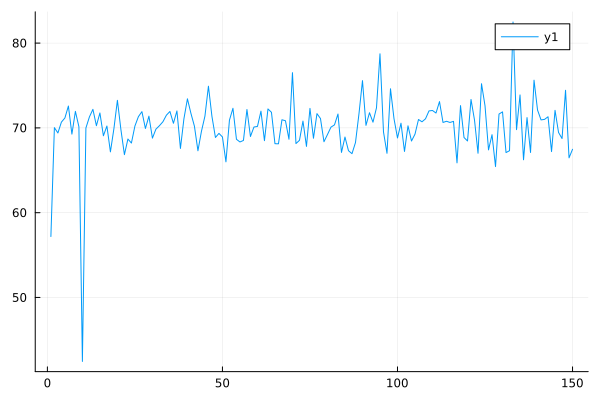

In [26]:
plot(episode_test_reward_hook.rewards)

In [27]:
close_visualization(); # closes the MeshCat visualization

# Evaluation

In [28]:
test_env = VtolEnv(;name = "testVTOL");

In [29]:
function loadModel(path, num)
    f = joinpath(path, "vtol_2D_ppo_$num.bson") # TODO: evtl anpassen
    @load f model
    return model
end;

In [30]:
function validate(num_models, num_test)
    episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
    # create a env only for reward test
    #todo evtl mit multithreding
    for i in 1:num_models
          
        sum_rewards_model = 0;
        sum_successes_model = 0;
        sum_avg_vel_model = 0;
        sum_compl_time = 0;
        n_success = 0;
        
        for exp in 1:num_test
            RLBase.reset!(test_env)
            if SLOW_MODE
                path = "./RL_models_slow/"
            else
                path = "./RL_models_fast/"
            end
            agent.policy.approximator = loadModel(path, i * 10_000); 
            run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
            # the result of the hook
            sum_rewards_model += episode_test_reward_hook.rewards[end];
            
            if test_env.reached_goal == trues(test_env.num_waypoints)
                n_success += 1
                sum_avg_vel_model += test_env.norm_way / test_env.t
                sum_compl_time += test_env.t
            end
        end
        
        rewards[i] = sum_rewards_model / num_test;
        success_rate[i] = n_success / num_test;
        if n_success > 0
            avg_velocity[i] = sum_avg_vel_model / n_success;
            avg_compl_time[i] = sum_compl_time / n_success;
        else
            avg_velocity[i] = NaN
            avg_compl_time[i] = NaN
        end
        percent = percent = round(i * 100 / num_models, digits=2)
        print("progress: $(percent)%   \r")
        flush(stdout)
        
    end
    
    
end;

In [31]:
num_model = Int(steps / 10_000)
num_test = 100 # TODO: change as desired 

rewards = zeros(num_model, 1);
success_rate = zeros(num_model, 1);
avg_velocity = zeros(num_model, 1);
avg_compl_time = zeros(num_model, 1);

validate(num_model, num_test)

In [32]:
fig_path = pwd() * "/plots/";
if SLOW_MODE
    fig_path = fig_path * "slow/"
else
    fig_path = fig_path * "fast/"
end

"/home/larissa/Documents/Projects/Advanced Deep Learning for Robotics/ADLR_project/src/2d/plots/fast/"

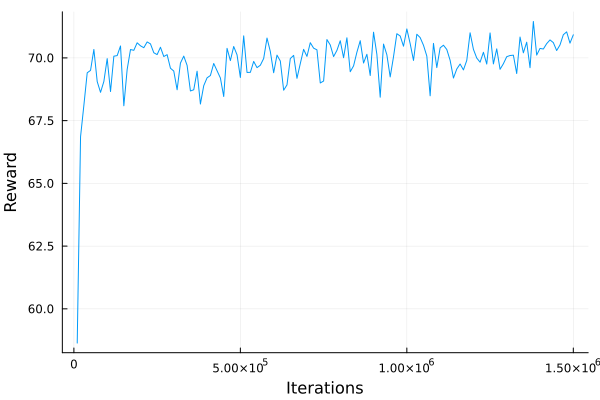

In [33]:
plot([1:num_model] * 10000, rewards, xlabel="Iterations", ylabel="Reward", legend = false, xformatter = :scientific)

In [34]:
savefig(fig_path * "reward.svg")

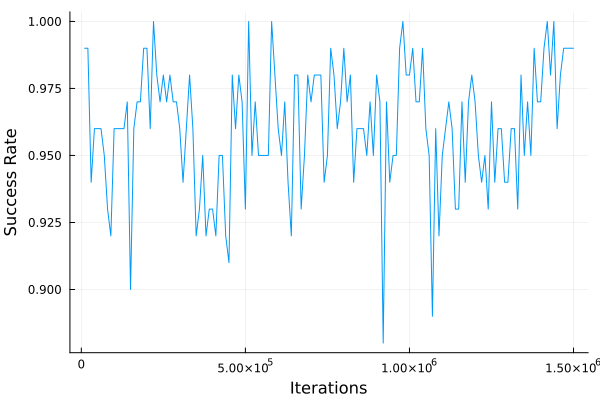

In [35]:
plot([1:num_model] * 10000, success_rate, xlabel="Iterations", ylabel="Success Rate", legend = false, xformatter = :scientific)

In [36]:
savefig(fig_path * "success_rate.svg")

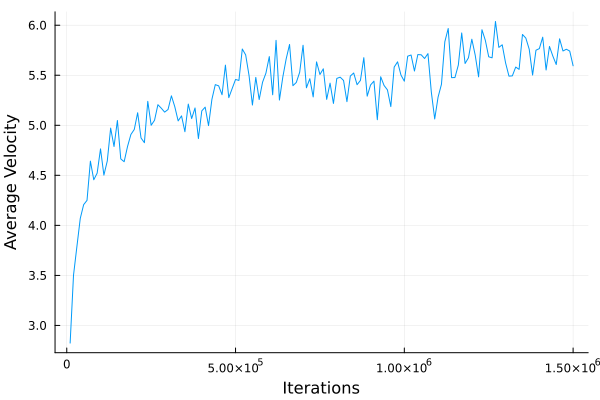

In [37]:
plot([1:num_model] * 10000, avg_velocity, xlabel="Iterations", ylabel="Average Velocity", legend = false, xformatter = :scientific)

In [38]:
savefig(fig_path * "avg_velocity.svg")

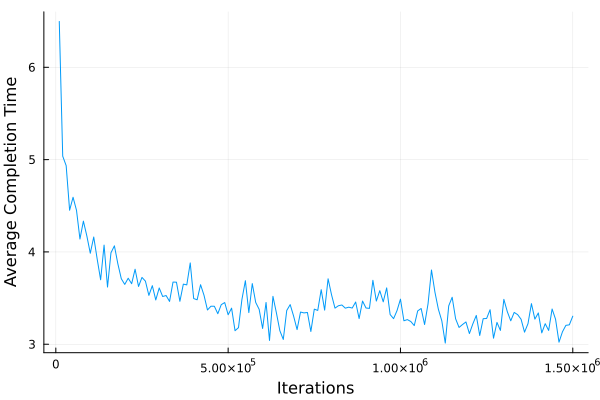

In [39]:
plot([1:num_model] * 10000, avg_compl_time, xlabel="Iterations", ylabel="Average Completion Time", legend = false, xformatter = :scientific)

In [40]:
savefig(fig_path * "avg_comp_time.svg")

done